### Position column transformation

In [2]:
def map_position_to_pnum(file):
    position_map = {
        "G": 1,
        "F": 1,
        "Forward": 1,
        "G-F": 2,
        "Guard": 1,
        "C-F": 2,
        "C": 1,
        "Guard/Forward": 2,
        "F-C": 2,
        "F-G": 2,
        "Center": 1,
        "Forward/Center": 2,
    }

    file['POSITION'] = file['POSITION'].map(position_map)
    return df

## Load data

In [3]:
import pandas as pd
#file_path = r'D:\MADS\Capstone\nba_players_stats_3.csv'

df = pd.read_csv("data/nba_players_stats_2.csv")
df_prep=map_position_to_pnum(df)
feature_cols=['AGE','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST',
                   'TOV','STL','BLK','BLKA','PF','PFD','PTS','EXP','Games Missed','HEIGHT','WEIGHT','POSITION']
df_features = df_prep[feature_cols]

In [4]:
df_features

,AGE,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,...,BLK,BLKA,PF,PFD,PTS,EXP,Games Missed,HEIGHT,WEIGHT,POSITION
0,23,121,13,50,15,23,14,36,20,14,...,3,8,22,13,136,1,0,78,179,1
1,24,196,69,169,17,19,9,55,30,12,...,4,3,49,20,252,1,4,76,190,1
2,20,62,10,39,2,2,2,16,5,8,...,2,3,6,1,48,1,25,78,220,1
3,28,716,40,138,177,269,174,297,259,105,...,45,57,142,223,1013,9,9,80,235,1
4,27,417,84,217,58,63,23,100,140,53,...,6,20,125,65,514,5,0,72,185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,25,1199,184,484,268,334,41,248,254,206,...,28,86,131,243,1530,5,5,78,200,2
2781,22,12,3,8,1,1,0,6,3,3,...,0,0,4,1,10,0,0,77,205,1
2782,21,11,0,3,2,4,0,2,2,2,...,0,1,4,2,8,1,3,75,205,1
2783,19,360,6,14,114,178,64,86,50,59,...,9,39,42,133,540,0,45,78,284,1


### DBSCAN

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

### EPS selection by finding the elbow point.

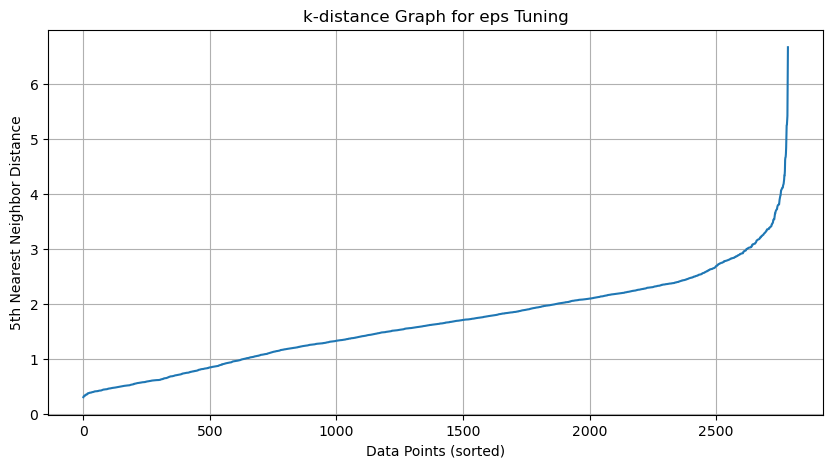

In [18]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Use your scaled feature data (after StandardScaler)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to visualize the elbow
k_distances = np.sort(distances[:, 4])  # 4 = 5th nearest neighbor (0-based)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title('k-distance Graph for eps Tuning')
plt.xlabel('Data Points (sorted)')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

In [37]:
# Eps selected as 2.3 where the line seems to turn upward 
# Min_samples values selected as 10 to ahcieve a balanced cluster
db = DBSCAN(eps=2.3, min_samples=10)
df_prep['cluster'] = db.fit_predict(X_scaled)

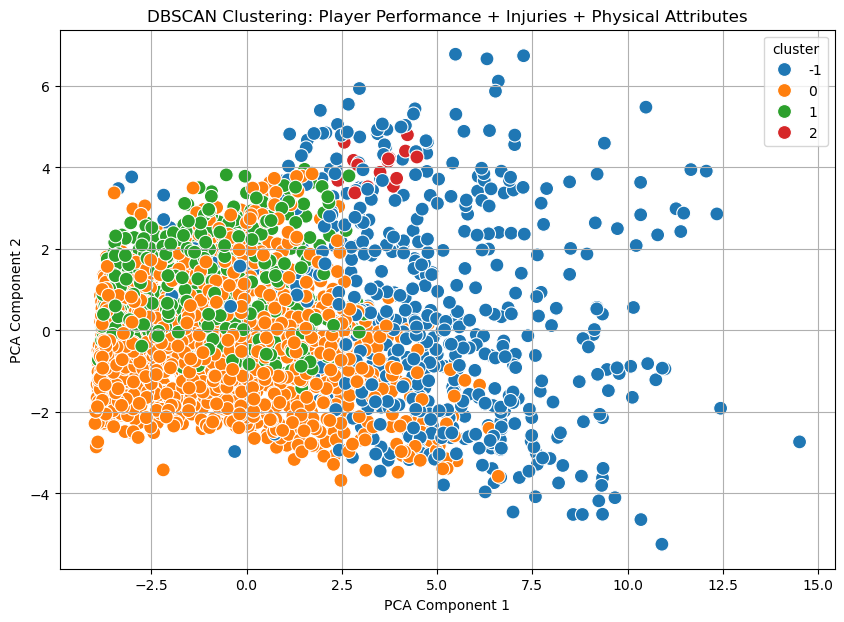

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_prep['pca1'] = X_pca[:, 0]
df_prep['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_prep, x='pca1', y='pca2', hue='cluster', palette='tab10', s=100)
plt.title('DBSCAN Clustering: Player Performance + Injuries + Physical Attributes')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend(title="cluster")
plt.show()

### DBSCAN Player Cluster Summary

In [52]:
import pandas as pd

# Set pandas to display ALL columns (no truncation)
pd.set_option('display.max_columns', None)



In [53]:
df_cluster=df_prep.groupby('cluster')[feature_cols].mean().round(1)
df_cluster

,AGE,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,EXP,Games Missed,HEIGHT,WEIGHT,POSITION
cluster,,,,,,,,,,,,,,,,,,,,,
-1,27.3,856.7,104.5,288.3,202.8,257.0,92.5,323.2,256.1,134.8,62.6,46.4,47.5,154.9,216.0,1135.1,6.3,11.3,79.3,223.8,1.4
0,25.9,261.2,42.6,117.6,42.2,54.3,27.9,93.8,74.4,37.6,24.2,12.8,13.9,62.6,49.9,319.3,3.4,9.8,77.6,210.9,1.0
1,25.6,230.9,32.7,93.5,40.8,55.2,37.9,107.2,54.4,33.4,23.7,17.3,13.4,71.4,50.5,290.1,3.6,12.8,79.8,223.2,2.0
2,25.3,558.5,3.4,12.7,143.9,204.4,205.8,437.5,106.4,95.4,38.5,79.6,38.8,169.6,191.8,851.6,4.8,9.3,83.2,246.4,1.0


### Evaluation 

In [56]:
### Silhouette Score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_scaled, db.labels_)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.080


In [57]:
import numpy as np
outlier_pct = np.mean(db.labels_ == -1)
print(f"Outlier Percentage: {outlier_pct * 100:.2f}%")

Outlier Percentage: 18.96%
